<a href="https://colab.research.google.com/github/jothivasan17/db/blob/main/LungcancerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
import torch.optim as optim
class FNNClassifier(nn.Module):
    def __init__(self, input_size=224*224*3, hidden_size=512, num_classes=4):
        super(FNNClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define VGG16-based segmentation model
class VGG16Segmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16Segmentation, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.upsample(x)
        return x

# Initialize models, loss, and optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# FNN Classifier
fnn_model = FNNClassifier().to(device)
fnn_criterion = nn.CrossEntropyLoss()
fnn_optimizer = optim.Adam(fnn_model.parameters(), lr=0.001)

# VGG16 Segmentation
seg_model = VGG16Segmentation().to(device)
seg_criterion = nn.BCELoss()
seg_optimizer = optim.Adam(seg_model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


In [ ]:
def load_models(classifier_path, segmentation_path, device):
    # Load classification model (VGG16) - modified to match saved architecture
    fnn_model = models.vgg16(pretrained=False)
    # Modify fnn_model's architecture to match the saved state_dict
    # Assuming the saved model had 'fc1' and 'fc2' layers:
    fnn_model = FNNClassifier().to(device)
    fnn_model.load_state_dict(torch.load(classifier_path, map_location=device))
    fnn_model.eval()

    # Load segmentation model (U-Net)
    seg_model = VGG16Segmentation().to(device)  # Assuming VGG16Segmentation is your U-Net class
    seg_model.load_state_dict(torch.load(segmentation_path, map_location=device))
    seg_model.to(device)

    return fnn_model, seg_model

In [ ]:
def get_predictions(image_path, fnn_model, seg_model, device):
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Class names
    class_names = [
        'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
        'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
        'normal',
        'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
    ]

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Classification
    fnn_model.eval()
    with torch.no_grad():
        cls_output = fnn_model(input_tensor)
        _, cls_pred = torch.max(cls_output, 1)
        predicted_class = class_names[cls_pred.item()]

    # Segmentation
    seg_model.eval()
    with torch.no_grad():
        seg_output = seg_model(input_tensor)
        seg_mask = (seg_output > 0.5).float().squeeze().cpu().numpy()

    # Draw bounding box
    image_np = np.array(image.resize((224, 224)))
    mask_uint8 = (seg_mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_np, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Predicted: {predicted_class}')
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Segmentation Mask')
    plt.imshow(seg_mask, cmap='gray')
    plt.axis('off')

    plt.show()

    return predicted_class, seg_mask, image_np

In [ ]:
# Example usage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model paths
classifier_path = "/home/Models/fnn_classifier.pth"
segmentation_path = "/home/Models/vgg16_segmentation.pth"

# Load models
fnn_model, seg_model = load_models(classifier_path, segmentation_path, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-ctscan-images


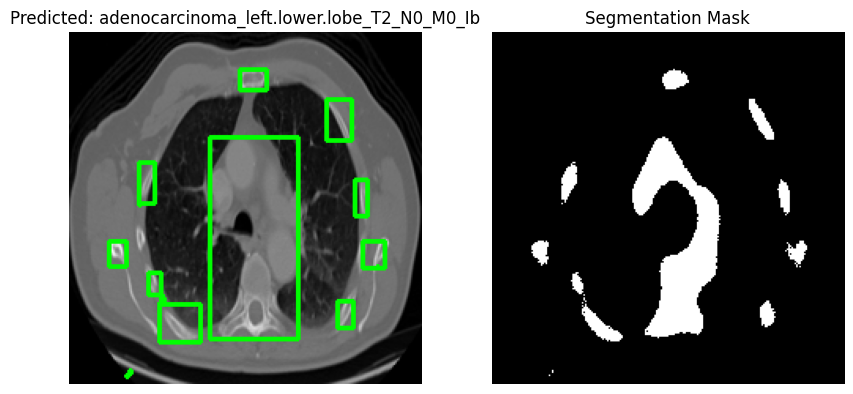

Predicted Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [ ]:
# Test image path
image_path = "/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000005 (3).png"

# Get predictions
predicted_class, seg_mask, output_image = get_predictions(image_path, fnn_model, seg_model, device)
print(f"Predicted Class: {predicted_class}")

In [ ]:
def classify_image(image_path, model_path='/home/Models/fnn_classifier.pth'):
    """
    Function to load FNN classifier and perform classification on an input image.

    Args:
        image_path (str): Path to the input image.
        model_path (str): Path to the trained FNN classifier model.

    Returns:
        predicted_class (str): Predicted class label.
    """
    # Device configuration
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load FNN model
    fnn_model = FNNClassifier().to(device)
    fnn_model.load_state_dict(torch.load(model_path, map_location=device))
    fnn_model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Classification
    with torch.no_grad():
        cls_output = fnn_model(input_tensor)
        _, cls_pred = torch.max(cls_output, 1)
        class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
        predicted_class = class_names[cls_pred.item()]

    # Display result
    plt.figure(figsize=(5, 5))
    plt.title(f'Predicted: {predicted_class}')
    plt.imshow(image.resize((224, 224)))
    plt.axis('off')
    plt.show()

    return predicted_class

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-ctscan-images


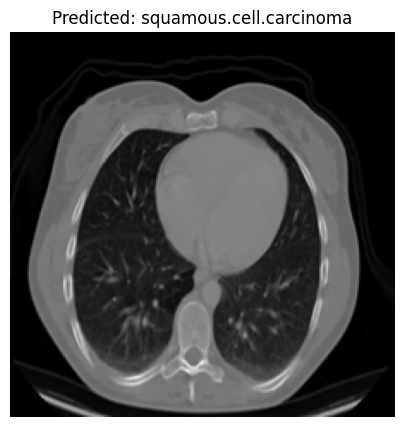

Predicted Class: squamous.cell.carcinoma


In [ ]:
test_image_path = '/kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000108 (3).png'
predicted_class = classify_image(test_image_path)
print(f"Predicted Class: {predicted_class}")